In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
import random
import wandb
from sklearn.metrics import roc_curve

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
dataset_path = '/kavesnin/delete_this/dataset/'

In [4]:
class AnomalyDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train', train_split=0.95):
        self.transform = transform
        self.mode = mode
        
        if mode == 'test':
            self.root_dir = os.path.join(root_dir, 'imgs')
            self.annotations = {}
            with open(os.path.join(root_dir, 'test_annotation.txt'), 'r') as f:
                for line in f:
                    img_name, label = line.strip().split()
                    self.annotations[img_name] = int(label)
            self.image_files = list(self.annotations.keys())
        else:
            self.root_dir = root_dir
            all_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
            if mode in ['train', 'val']:
                np.random.seed(42)
                np.random.shuffle(all_files)
                split_idx = int(len(all_files) * train_split)
                
                self.image_files = all_files[:split_idx] if mode == 'train' else all_files[split_idx:]
            else:
                self.image_files = all_files
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.mode == 'test':
            label = self.annotations[img_name]
            return image, label
        
        return image

    def get_image(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        return image

In [18]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

no_anomaly_train_dataset = AnomalyDataset(os.path.join(dataset_path, 'train'), transform=transform, mode='train')
no_anomaly_val_dataset = AnomalyDataset(os.path.join(dataset_path, 'train'), transform=transform, mode='val')
proliv_dataset = AnomalyDataset(os.path.join(dataset_path, 'proliv'), transform=transform, mode='train')
test_dataset = AnomalyDataset(os.path.join(dataset_path, 'test'), transform=transform, mode='test')

In [19]:
no_anomaly_train_loader = DataLoader(no_anomaly_train_dataset, batch_size=64, shuffle=True)
no_anomaly_val_loader = DataLoader(no_anomaly_val_dataset, batch_size=64, shuffle=False)
proliv_loader = DataLoader(proliv_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [21]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [6]:
def get_tpr_and_tnr(pred, real):
    pred = np.array(pred)
    real = np.array(real)
    
    tp = np.sum((pred == 1) & (real == 1))
    tn = np.sum((pred == 0) & (real == 0))
    fp = np.sum((pred == 1) & (real == 0))
    fn = np.sum((pred == 0) & (real == 1))
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    return tpr, tnr

In [7]:
def calculate_threshold(model, anomaly_loader):
    model.eval()
    criterion = nn.MSELoss(reduction='none')
    
    anomaly_scores = []
    
    with torch.no_grad():  
        for batch in anomaly_loader:
            batch = batch.to(device)
            outputs = model(batch)
            reconstruction_error = criterion(outputs, batch).mean(dim=(1,2,3))
            anomaly_scores.extend(reconstruction_error.cpu().numpy())
    
    y_true = [1] * len(anomaly_scores)
    
    _, tpr, thresholds = roc_curve(y_true, anomaly_scores)
    optimal_idx = np.argmax(tpr > 0.96)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold

In [8]:
def evaluate_model(model, test_loader, threshold):
    model.eval()
    criterion = nn.MSELoss(reduction='none')
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch, labels in test_loader:
            batch = batch.to(device)
            outputs = model(batch)
            reconstruction_error = criterion(outputs, batch).mean(dim=(1,2,3))
            predictions = (reconstruction_error > threshold).cpu().numpy().astype(int)
            
            all_predictions.extend(predictions)
            all_labels.extend(labels.numpy())
    
    return get_tpr_and_tnr(all_predictions, all_labels)

In [9]:
def train_autoencoder(
    model, 
    train_loader, val_loader, proliv_loader, test_loader, 
    criterion, 
    optimizer, scheduler, 
    num_epochs
):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader):
            batch = batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch)
            
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        scheduler.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)

        threshold = calculate_threshold(model, proliv_loader)
        tpr, tnr = evaluate_model(model, test_loader, threshold)

        wandb.log(
            {
                'train_loss': avg_train_loss, 
                'test_loss': avg_val_loss,
                'true_positive_rate': tpr,
                'true_negative_rate': tnr,
            }
        )

In [12]:
wandb.init(
    project='Homework-2',
    name='my_baseline'
)

wandb: Currently logged in as: kavesnin (kavesnin-hse). Use `wandb login --relogin` to force relogin


In [26]:
num_epochs = 15
train_autoencoder(
    model, 
    no_anomaly_train_loader, no_anomaly_val_loader, proliv_loader, test_loader, 
    criterion, 
    optimizer, scheduler, 
    num_epochs
)

wandb.finish()

  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


test_loss,█▃▂▁▂▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
true_negative_rate,█▁█████████████
true_positive_rate,▆█▆▁▁▃▆▆▆▆▆▆▆▆█
test_loss,1e-05
train_loss,1e-05
true_negative_rate,0.98854
true_positive_rate,0.77519


In [27]:
threshold = calculate_threshold(model, proliv_loader)
threshold

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


7.318347e-05

In [28]:
tpr, tnr = evaluate_model(model, test_loader, threshold)
print('True Positive Rate:', tpr)
print('True Negative Rate:', tnr)

True Positive Rate: 0.7751937984496124
True Negative Rate: 0.9885402455661665


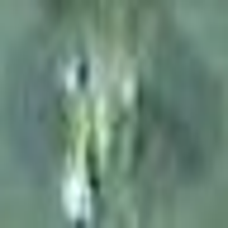

In [33]:
proliv_dataset.get_image(2).resize((256, 256))

In [10]:
def generate(inputs):
    model.eval()
    with torch.no_grad():
        output = model(inputs.to(device))
        output_image = transforms.ToPILImage()(output.cpu())
    return output_image

def show_by_ind(dataset, ind):
    image = dataset.get_image(ind).resize((256, 256))
    image.show()
    output_image = generate(dataset[ind])
    output_image.show()

In [52]:
im = Image.open('/kavesnin/denis_photo.jpg')
np.array(im)[0][0]

array([120, 116, 104], dtype=uint8)

Anomaly №1


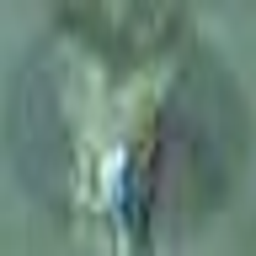

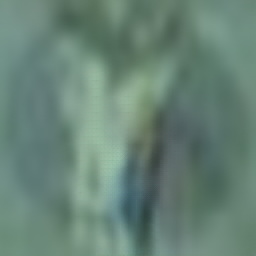

Anomaly №2


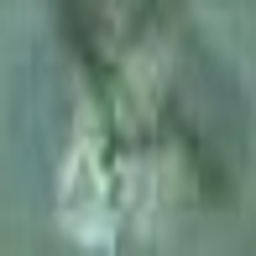

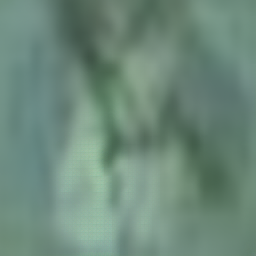

Anomaly №3


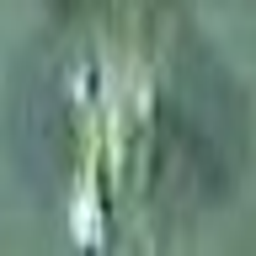

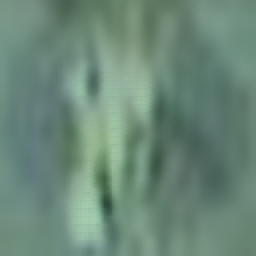

Anomaly №4


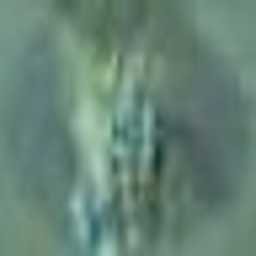

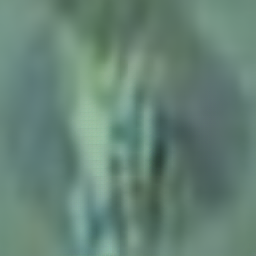

Anomaly №5


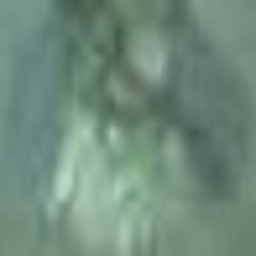

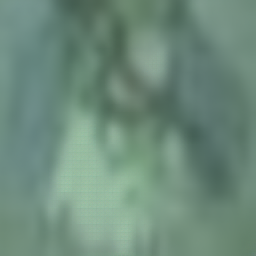

In [53]:
for i in range(5):
    print(f"Anomaly №{i + 1}")
    show_by_ind(proliv_dataset, i)

# Эксперимент с архитектурой
Цель: улучшить метрики.\
Идея: уменьшить кол-во параметров AutoEncoder, чтобы кодировалось менее качественно и повысилась чувствительность к аномалиям.

In [22]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

no_anomaly_train_dataset = AnomalyDataset(os.path.join(dataset_path, 'train'), transform=transform, mode='train')
no_anomaly_val_dataset = AnomalyDataset(os.path.join(dataset_path, 'train'), transform=transform, mode='val')
proliv_dataset = AnomalyDataset(os.path.join(dataset_path, 'proliv'), transform=transform, mode='train')
test_dataset = AnomalyDataset(os.path.join(dataset_path, 'test'), transform=transform, mode='test')

In [23]:
no_anomaly_train_loader = DataLoader(no_anomaly_train_dataset, batch_size=64, shuffle=True)
no_anomaly_val_loader = DataLoader(no_anomaly_val_dataset, batch_size=64, shuffle=False)
proliv_loader = DataLoader(proliv_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [34]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 2, 3, stride=2, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [35]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [37]:
wandb.init(
    project='Homework-2',
    name='exp_less_parameters'
)

In [38]:
num_epochs = 15
train_autoencoder(
    model, 
    no_anomaly_train_loader, no_anomaly_val_loader, proliv_loader, test_loader, 
    criterion, 
    optimizer, scheduler, 
    num_epochs
)

wandb.finish()

  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


test_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁
true_negative_rate,▁▄▇████████████
true_positive_rate,██▃▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.00241
train_loss,0.00234
true_negative_rate,0.8292
true_positive_rate,0.93023


In [39]:
threshold = calculate_threshold(model, proliv_loader)
threshold

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


0.0042029396

In [40]:
tpr, tnr = evaluate_model(model, test_loader, threshold)
print('True Positive Rate:', tpr)
print('True Negative Rate:', tnr)

True Positive Rate: 0.9302325581395349
True Negative Rate: 0.8291950886766712


Вывод: Сложно сравнивать графики 

# Эксперимент с подсчётом threshold-а
Цель: Увеличить точность на данных без аномалии.\
Идея: Учитывать при подборе порога не только proliv, но и данные без аномалии (val-датасет). Тогда порог должен лучше подстраиваться под точность для данных без аномалии. Искать не через пороги roc-curve, а через бинарный поиск.

In [41]:
def calculate_threshold(model, no_anomaly_val_loader, anomaly_loader):
    model.eval()
    criterion = nn.MSELoss(reduction='none')
    
    anomaly_scores = []
    no_anomaly_scores = []
    
    with torch.no_grad():  
        for batch in anomaly_loader:
            batch = batch.to(device)
            outputs = model(batch)
            reconstruction_error = criterion(outputs, batch).mean(dim=(1,2,3))
            anomaly_scores.extend(reconstruction_error.cpu().numpy())

        for batch in no_anomaly_val_loader:
            batch = batch.to(device)
            outputs = model(batch)
            reconstruction_error = criterion(outputs, batch).mean(dim=(1,2,3))
            no_anomaly_scores.extend(reconstruction_error.cpu().numpy())
    
    y_true = [1] * len(anomaly_scores) + [0] * len(no_anomaly_scores)
    all_scores = anomaly_scores + no_anomaly_scores
    
    def evaluate_threshold(threshold):
        predictions = [1 if score > threshold else 0 for score in all_scores]
        tpr, tnr = get_tpr_and_tnr(predictions, y_true)
        return tpr * tnr
    
    # Бинарный поиск
    left = min(all_scores)
    right = max(all_scores)
    best_threshold = left
    best_score = evaluate_threshold(left)
    
    for _ in range(100):
        mid1 = left + (right - left) / 3
        mid2 = right - (right - left) / 3
        
        score1 = evaluate_threshold(mid1)
        score2 = evaluate_threshold(mid2)
        
        if score1 > best_score:
            best_score = score1
            best_threshold = mid1
            
        if score2 > best_score:
            best_score = score2
            best_threshold = mid2
        
        if score1 > score2:
            right = mid2
        else:
            left = mid1
    
    return best_threshold

In [42]:
threshold = calculate_threshold(model, no_anomaly_val_loader, proliv_loader)
threshold

0.004114039175472079

In [43]:
tpr, tnr = evaluate_model(model, test_loader, threshold)
print('True Positive Rate:', tpr)
print('True Negative Rate:', tnr)

True Positive Rate: 0.9302325581395349
True Negative Rate: 0.8223738062755798


Вывод: подбор threshold-а не поменялся, порог подбирался верной стратегией, и сдвигать его для баланса на тестовых данных было бы переобучением на тестовых данных.